# Logistic Classification

In [1]:
# Import dependencies
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
logreg = lm.LogisticRegression()
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import datasets
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from collections import OrderedDict

DISPLAY_PRECISION = 4
pd.set_option("display.precision", DISPLAY_PRECISION)

# Loading in CSV

In [2]:
# Import CSV
url1 = 'https://raw.githubusercontent.com/eenabow/oscar_nominations/main/data/oscars2_df.csv'
test1_df = pd.read_csv(url1, index_col=None)

In [3]:
# Preview the dataset
test1_df.head()

,movie,duration,metascore,gross,critic_reviews,awards_wins,popularity,awards_nominations,golden_globes_nominated,oscar_nominated
0,Kate & Leopold,118,44.0,4.7100e+07,125.0,1,2363.0,4,2,1
1,Chicken Run,84,88.0,1.0679e+08,186.0,5,2859.0,11,1,0
2,Fantastic Four,106,40.0,1.5470e+08,278.0,0,1876.0,0,0,0
3,Frida,123,61.0,2.5780e+07,126.0,2,2508.0,12,2,1
4,The Lord of the Rings: The Fellowship of the Ring,178,92.0,3.1384e+08,296.0,26,204.0,67,4,1


In [4]:
# Will need to remove movie from test_df for actual model
test1_df = test1_df[["duration", "metascore", "gross", "critic_reviews", "awards_wins", "popularity", "awards_nominations", "golden_globes_nominated", "oscar_nominated"]]
test1_df.head()

,duration,metascore,gross,critic_reviews,awards_wins,popularity,awards_nominations,golden_globes_nominated,oscar_nominated
0,118,44.0,4.7100e+07,125.0,1,2363.0,4,2,1
1,84,88.0,1.0679e+08,186.0,5,2859.0,11,1,0
2,106,40.0,1.5470e+08,278.0,0,1876.0,0,0,0
3,123,61.0,2.5780e+07,126.0,2,2508.0,12,2,1
4,178,92.0,3.1384e+08,296.0,26,204.0,67,4,1


# Logistic Classifaction Machine Learning using grid search CV

In [5]:
# Labels are the values we want to predict
labels = np.array(test1_df['oscar_nominated'])

# Remove the labels from the features
# axis 1 refers to the columns
features= test1_df.drop('oscar_nominated', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [6]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [7]:
# Print the shape of the test and train splits
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (783, 8)
Training Labels Shape: (783,)
Testing Features Shape: (261, 8)
Testing Labels Shape: (261,)


In [8]:
# define model
model = LogisticRegression(max_iter=100)

In [9]:
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [10]:
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

In [11]:
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

In [12]:
# execute search
result = search.fit(train_features, train_labels)
result

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [13]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8646597425078437
Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


# Predict whether Nomadland (Won Oscar's Best Picture 2021) would be nominated for the Oscar's based on model

In [14]:
# Manually enter nomadland features
nomadland_df = pd.DataFrame({
    "duration": [110],
    "metascore": [93],
    "gross": [2143000],
    "critic_reviews": [303],
    "awards_wins": [227],
    "popularity": [11],
    "awards_nominations": [41], 
    "golden_globes_nominated": [4]
})

In [15]:
search.predict(nomadland_df)

array([1])

# Visualize best parameters of the model and weights of features

In [16]:
# Save features columns as a list 
columns_list = list(test1_df.columns)[0:-1]
columns_list

['duration',
 'metascore',
 'gross',
 'critic_reviews',
 'awards_wins',
 'popularity',
 'awards_nominations',
 'golden_globes_nominated']

In [17]:
# Find the weights of each feature and how they impact the score
feature_imp = result.best_estimator_.coef_
feature_imp = feature_imp[0]
feature_imp

array([ 2.37160433e-02,  3.70325124e-02,  2.31846297e-09, -1.44057507e-03,
        7.68357652e-02,  7.19528588e-04,  1.89195669e-01,  5.95507412e-01])

No handles with labels found to put in legend.


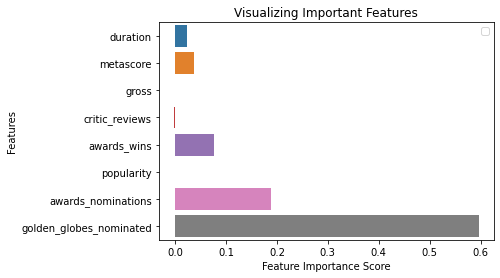

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=columns_list)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()
plt.savefig('Logistic_Classification_importantfeatures.png')

In [19]:
# Export the SAV machine learning file 
import joblib

joblib.dump(search, "logistic_classifaction_oscars.joblib")

['logistic_classifaction_oscars.joblib']